In [16]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
import string

In [17]:
def replace_polish_lowercase(text):
    polish_to_latin = {
        'ą': 'a', 'ć': 'c', 'ę': 'e', 'ł': 'l', 'ń': 'n', 
        'ó': 'o', 'ś': 's', 'ź': 'z', 'ż': 'z'
    }
    return ''.join(polish_to_latin.get(char, char) for char in text)

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove polish letters
    text = replace_polish_lowercase(text)
    # Tokenize (split by whitespace)
    tokens = text.split()
    return ' '.join(tokens)  # Join tokens back into a string for TF-IDF

In [18]:
FILENAME_DEV = './data/dataset_conll/all.sentence.dev.txt'
FILENAME_TRAIN = './data/dataset_conll/all.sentence.train.txt'
FILENAME_TEST = './data/dataset_conll/all.sentence.test.txt'

LABELS = {
    "__label__z_minus_m": "Negative sentiment", 
    "__label__z_plus_m": "Positive sentiment",
    "__label__z_zero": "No sentiment",
    "__label__z_amb": "Unsure",
    }


In [19]:
def load_df(filename):
    with open(filename, 'r', encoding="utf8") as f:
        lines = f.readlines()
        data = [line.strip() for line in lines]
        # get last word from each item as a label and match with data
        labeled_data = []
        for item in data:
            label = item.split()[-1]
            sentence_data = ' '.join(item.split()[:-1])
            labeled_data.append((sentence_data, LABELS[label]))

        # create a dataframe
        df = pd.DataFrame(labeled_data, columns=['sentence', 'label'])
        return df

# Read data

In [20]:
df_train = load_df(FILENAME_TRAIN)
df_test = load_df(FILENAME_TEST)

Early preprocessing

In [21]:
df_train['processed_sentence'] = df_train['sentence'].apply(preprocess_text)
df_test['processed_sentence'] = df_test['sentence'].apply(preprocess_text)

In [22]:
df_train.sample(5)

,sentence,label,processed_sentence
40311,"Z domów zakonnych raczej nie zrezygnuje , to t...",Negative sentiment,z domow zakonnych raczej nie zrezygnuje to tyl...
22133,"Hotel o klimacie dość industrialnym , uniwersa...",Positive sentiment,hotel o klimacie dosc industrialnym uniwersaln...
13523,"Dodatkowo Pan Doktor był mało empatyczny , a j...",Negative sentiment,dodatkowo pan doktor byl malo empatyczny a ja ...
17232,Gdy sięgamy po nie od jednego do trzech razy d...,No sentiment,gdy siegamy po nie od jednego do trzech razy d...
37540,Jednakże uważajcie .,Unsure,jednakze uwazajcie


In [23]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df_train['processed_sentence'])  # Fit on train data
X_test = vectorizer.transform(df_test['processed_sentence'])  # Transform test data

In [24]:
# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
y_train = encoder.fit_transform(df_train[['label']])  # Fit on train data labels
y_test = encoder.transform(df_test[['label']])       # Transform test data labels

# Classification

In [25]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
def plot_confusion_matrix(cm):
    class_names = ["Negative sentiment", "Positive sentiment", "No sentiment", "Unsure"]  # Nazwy klas

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Confusion Matrix")
    plt.show()

## Decision Tree

In [27]:
# Decision Tree Classifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)  # Fit only on train data

DecisionTreeClassifier()

In [28]:
y_pred_dt = classifier.predict(X_test)

In [29]:
# Get bit mask where prediction isn't valid one hot encoding
valid_mask = y_pred_dt.sum(axis=1) == 1
y_pred_dt = y_pred_dt[valid_mask]
y_test_dt = y_test[valid_mask]
print(f"Couldn't predict {len(df_test) - len(y_pred_dt)} samples")

Couldn't predict 3 samples


In [30]:
y_pred_labels = encoder.inverse_transform(y_pred_dt)
y_test_labels = encoder.inverse_transform(y_test_dt)

In [31]:
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"Decision Tree Accuracy: {accuracy:.2f}")

dt_precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
print(f"Decision Tree Precision: {dt_precision:.2f}")

dt_recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
print(f"Decision Tree Recall: {dt_recall:.2f}")

dt_f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
print(f"Decision Tree F1-Score: {dt_f1:.2f}")

y_proba = classifier.predict_proba(X_test)
    
y_proba = np.array(y_proba)
y_proba = y_proba[:, :, 1].T
y_proba = y_proba[valid_mask] 
    
dt_auc = roc_auc_score(y_test_dt, y_proba, multi_class='ovr')
    
print(f"Decision Tree AUC: {dt_auc:.2f}")
dt_gini = 2 * dt_auc - 1
print(f"Decision Tree GINI: {dt_gini:.2f}")

Decision Tree Accuracy: 0.53
Decision Tree Precision: 0.52
Decision Tree Recall: 0.53
Decision Tree F1-Score: 0.52
Decision Tree AUC: 0.66
Decision Tree GINI: 0.32


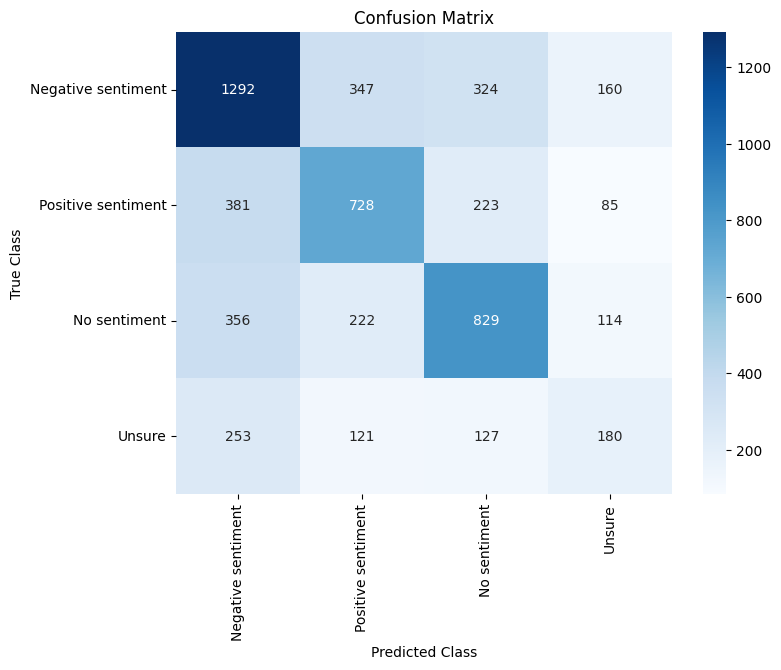

In [32]:
cm_dt = confusion_matrix(y_test_dt.argmax(axis=1), y_pred_dt.argmax(axis=1))
plot_confusion_matrix(cm_dt)

## Naive Bayes

In [33]:
nb_classifier = MultinomialNB()
y_train_labels = encoder.inverse_transform(y_train).ravel()
nb_classifier.fit(X_train, y_train_labels)

MultinomialNB()

In [34]:
y_nb_pred = nb_classifier.predict(X_test)

In [35]:
# Convert predictions to one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
y_nb_pred_onehot = encoder.fit_transform(y_nb_pred.reshape(-1, 1))

In [36]:
# Get bit mask where prediction isn't valid one hot encoding
valid_mask = y_nb_pred_onehot.sum(axis=1) == 1
y_nb_pred_onehot = y_nb_pred_onehot[valid_mask]
y_test_nb = y_test[valid_mask]

if(len(y_test) - len(y_nb_pred_onehot) > 0):
    print(f"Couldn't predict {len(y_test) - len(y_nb_pred_onehot)} samples with Naive Bayes")


In [37]:
nb_accuracy = accuracy_score(y_test_nb.argmax(axis=1), y_nb_pred_onehot.argmax(axis=1))
print(f"Naive Bayes Accuracy: {nb_accuracy:.2f}")

nb_precision = precision_score(y_test_nb.argmax(axis=1), y_nb_pred_onehot.argmax(axis=1), average='macro')
print(f"Naive Bayes Precision: {nb_precision:.2f}")

nb_recall = recall_score(y_test_nb.argmax(axis=1), y_nb_pred_onehot.argmax(axis=1), average='macro')
print(f"Naive Bayes Recall: {nb_recall:.2f}")

nb_f1 = f1_score(y_test_nb.argmax(axis=1), y_nb_pred_onehot.argmax(axis=1), average='macro')
print(f"Naive Bayes F1-Score: {nb_f1:.2f}")

y_nb_proba = nb_classifier.predict_proba(X_test)
nb_auc = roc_auc_score(y_test_nb, y_nb_proba, multi_class='ovr')
print(f"Naive Bayes AUC: {nb_auc:.2f}")

nb_gini = 2 * nb_auc - 1
print(f"Naive Bayes GINI: {nb_gini:.2f}")

Naive Bayes Accuracy: 0.63
Naive Bayes Precision: 0.74
Naive Bayes Recall: 0.51
Naive Bayes F1-Score: 0.50
Naive Bayes AUC: 0.84
Naive Bayes GINI: 0.68


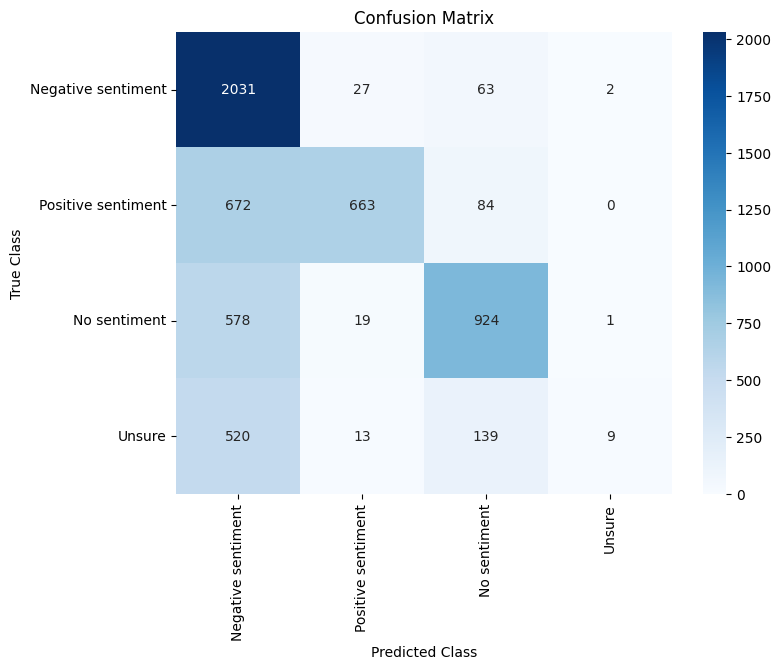

In [38]:
cm_nb = confusion_matrix(y_test_nb.argmax(axis=1), y_nb_pred_onehot.argmax(axis=1))
plot_confusion_matrix(cm_nb)

## Logistic Regression

In [39]:
lr_classifier = OneVsRestClassifier(LogisticRegression(max_iter=1000))
lr_classifier.fit(X_train, y_train.argmax(axis=1))

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000))

In [40]:
y_lr_pred = lr_classifier.predict(X_test)

In [41]:
# Convert predictions to one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
y_lr_pred_onehot = encoder.fit_transform(y_lr_pred.reshape(-1, 1))

In [42]:
valid_mask = y_lr_pred_onehot.sum(axis=1) == 1
y_lr_pred_onehot = y_lr_pred_onehot[valid_mask]
y_test_lr = y_test[valid_mask]
if(len(y_test) - len(y_lr_pred_onehot) > 0):
    print(f"Couldn't predict {len(y_test) - len(y_lr_pred_onehot)} samples with Logistic Regression")

In [43]:
lr_accuracy = accuracy_score(y_test_lr.argmax(axis=1), y_lr_pred_onehot.argmax(axis=1))
print(f"Logistic Regression Accuracy: {lr_accuracy:.2f}")

lr_precision = precision_score(y_test_lr.argmax(axis=1), y_lr_pred_onehot.argmax(axis=1), average='macro')
print(f"Logistic Regression Precision: {lr_precision:.2f}")

lr_recall = recall_score(y_test_lr.argmax(axis=1), y_lr_pred_onehot.argmax(axis=1), average='macro')
print(f"Logistic Regression Recall: {lr_recall:.2f}")

lr_f1 = f1_score(y_test_lr.argmax(axis=1), y_lr_pred_onehot.argmax(axis=1), average='macro')
print(f"Logistic Regression F1-Score: {lr_f1:.2f}")

y_lr_proba = lr_classifier.predict_proba(X_test)
lr_auc = roc_auc_score(y_test_lr, y_lr_proba, multi_class='ovr')
print(f"Logistic Regression AUC: {lr_auc:.2f}")

lr_gini = 2 * lr_auc - 1
print(f"Logistic Regression GINI: {lr_gini:.2f}")

Logistic Regression Accuracy: 0.69
Logistic Regression Precision: 0.69
Logistic Regression Recall: 0.62
Logistic Regression F1-Score: 0.64
Logistic Regression AUC: 0.87
Logistic Regression GINI: 0.74


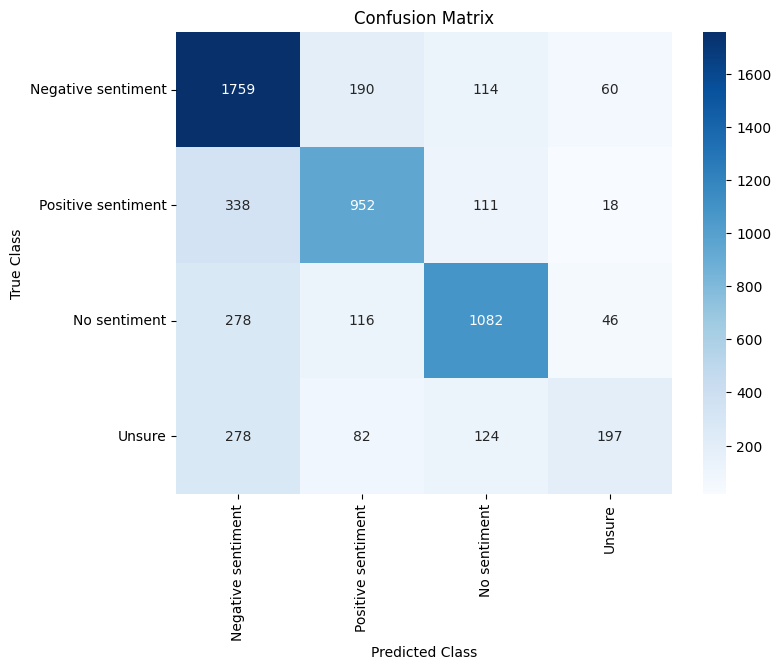

In [44]:
cm_lr = confusion_matrix(y_test_lr.argmax(axis=1), y_lr_pred_onehot.argmax(axis=1))
plot_confusion_matrix(cm_lr)